# inicializacao

In [2]:
import numpy as np
import pandas as pd
import sympy as sp
import scipy.io as sc 
import scipy.signal as signal
from sympy import symbols, pprint
import matplotlib.pyplot as plt
from structureSelector import *

from methods.utils.utilities import *
import plotly.express as px

def metrics(y, yest):
    residuo1 = y - yest
    mape = round(np.mean(np.abs(residuo1 / (yest + np.finfo(np.float64).eps))), 5)
    print('RMSE:', np.sqrt(np.mean(np.square(residuo1))), 'MSE:', np.mean(np.square(residuo1)), '\nAET:', np.sum(np.abs(residuo1)), '\nMAPE:', str(mape) + '%')

def integrate(p, ts=0.1):
    r = np.zeros(p.shape)
    r[0] = p[0] * ts
    for i in range(1, p.shape[0]):
        r[i] = r[i-1] + p[i] * ts
    return r


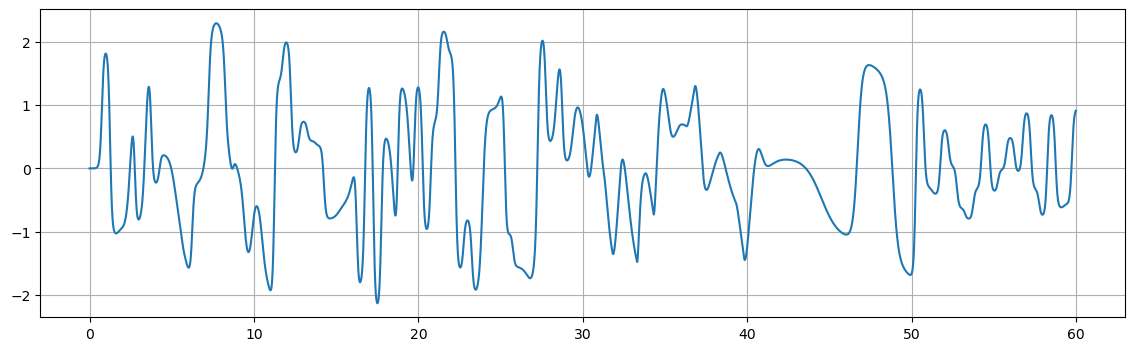

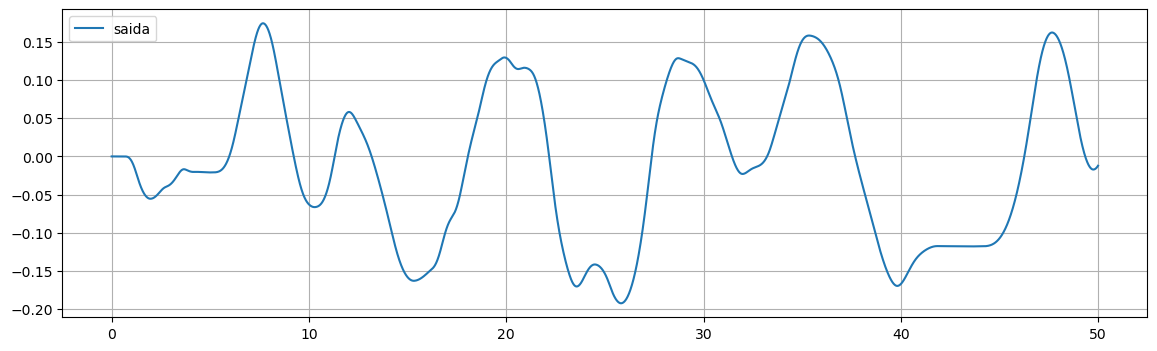

In [3]:
#my_data = np.genfromtxt('data/ballBeamTeste1.csv', delimiter=',')[1:,:]
my_data = np.genfromtxt('data/ballBeamFriction.csv', delimiter=',')[1:,:]
u = my_data[:, 0].copy()
y = my_data[:, 1].copy() 
t = my_data[:, -1].copy()

np.random.seed(15)
amplitude = 0.00001
#u += np.random.uniform(-0.0002, 0.0002, u.shape)
#y = y + np.random.uniform(-amplitude, amplitude, y.shape)

dt = my_data[1, -1]
size = 5000
plt.figure(figsize=(14, 4))
plt.plot(t, u*(180/np.pi), label="entrada")
plt.grid()
plt.show()
plt.figure(figsize=(14, 4))
plt.plot(t[:size], y[:size], label="saida")
plt.legend()
plt.grid()
plt.show()

# Estimacao

[Y1.1 cos(U1.2)*sign(Y1.1) U1.8*cos(Y1.1) Y1.8*cos(U1.5) Y1.2 U1.4 Y1.3
 Y1.4] [ 7.92788109e-01 -1.50013582e-04  4.88571097e-02 -3.40404667e-02
  4.04978019e-01 -9.91917704e-02 -9.62669771e-02 -6.74587014e-02] [1, 295, 218, 205, 2, 16, 3, 4]

Um passo a frente
RMSE: 7.900448218727423e-05 MSE: 6.241708205679332e-09 
AET: 0.35366417612275186 
MAPE: 0.15291%

Simulação livre
RMSE: 0.0007637376662686488 MSE: 5.83295222877482e-07 
AET: 3.368591499583175 
MAPE: 1.36749%
-0.0991917703555167*U1.4 + 0.0488571096896032*U1.8*cos(Y1.1) + 0.792788108618942*Y1.1 + 0.404978018533818*Y1.2 - 0.0962669771028004*Y1.3 - 0.0674587013573986*Y1.4 - 0.0340404667317299*Y1.8*cos(U1.5) - 0.000150013582271597*cos(U1.2)*sign(Y1.1)


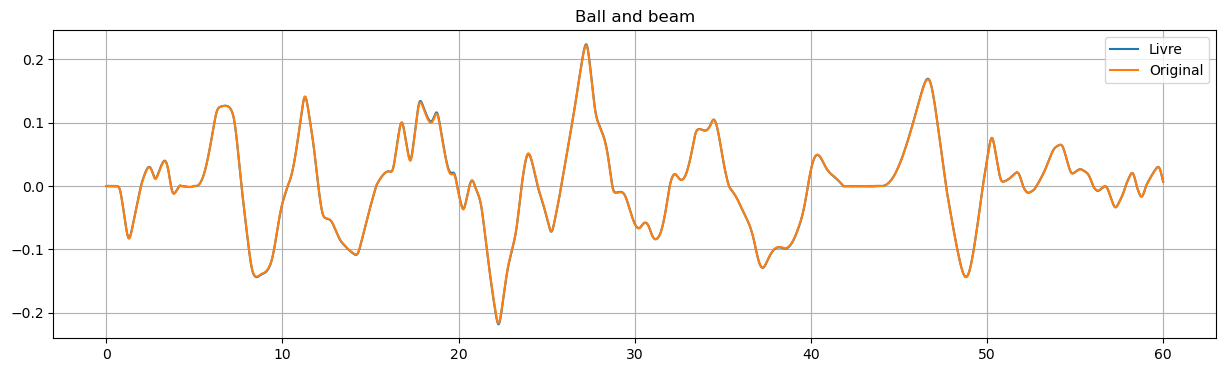

'\nUm passo a frente\nRMSE: 7.900448218727423e-05 MSE: 6.241708205679332e-09 \nAET: 0.35366417612275186 \nMAPE: 0.15291%\n\nSimulação livre\nRMSE: 0.0007637376662686488 MSE: 5.83295222877482e-07 \nAET: 3.368591499583175 \nMAPE: 1.36749%\n'

In [57]:
ui = np.reshape(u, (1, -1)).copy()
yi = np.reshape(y, (1, -1)).copy()
yi[0,1:] = (yi[0,1:] - yi[0,:-1]) / dt
#yi[0,1:] = (yi[0,1:] - yi[0,:-1]) / dt
'''yi = np.reshape(my_data[:, 1], (1, -1)).copy()

amplitude = 0.00001
yi = yi + np.random.uniform(-amplitude, amplitude, yi.shape)
delay = 0
'''
output = 0  
num = [10]
params = []
params.append({'nb':[8],'na':[8], 'level':2, 'nonlinear':[0,5,0,0,1], 'root':False, 'delay':2, 'diff':False, 'ymodifier':[0,0]})

sselector = structureSelector()
clip.setLimit(-0.2, 0.2)
ss = sselector.symbolic_regressors(**params[output], intg=False)

vCandidatos = sselector.matrix_candidate(ui, yi, **params[output], dt=dt, intg=False)

pad = max(max(params[output]['nb']), max(params[output]['na']))
aux = max(params[output]['nonlinear'])
pad = max(pad, aux)
psi, selected  = sselector.semp(vCandidatos.T, yi[output, pad:], num[output], 1e-13)

model = ss[selected]

theta = LSM(yi[output, pad:], psi)
print(model, theta, selected)

model = ss[selected]

yhat = sselector.oneStepForward2(u=ui, y=yi, theta=theta, selected=selected, nb=params[output]['nb'], na=params[output]['na'], level=params[output]['level'], index=output, root=params[output]['root'], delay=params[output]['delay'], diff=params[output]['diff'], dt=dt, intg=False, nonlinear=params[output]['nonlinear'], ymodifier=params[output]['ymodifier'])
print("\nUm passo a frente")
metrics(yi, yhat)

slivre = sselector.predict(ui, yi, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['delay'], params[output]['diff'], dt=dt, intg=False)
print("\nSimulação livre")
metrics(yi, slivre)

print(model @ theta)
plt.figure(figsize=(15,4));plt.title("Ball and beam")
plt.plot(t, slivre, label='Livre');#plt.ylim(-0.2,0.2);
plt.plot(t, yi.T, label='Original');plt.legend();plt.grid();plt.show()

'''
Um passo a frente
RMSE: 7.900448218727423e-05 MSE: 6.241708205679332e-09 
AET: 0.35366417612275186 
MAPE: 0.15291%

Simulação livre
RMSE: 0.0007637376662686488 MSE: 5.83295222877482e-07 
AET: 3.368591499583175 
MAPE: 1.36749%
'''


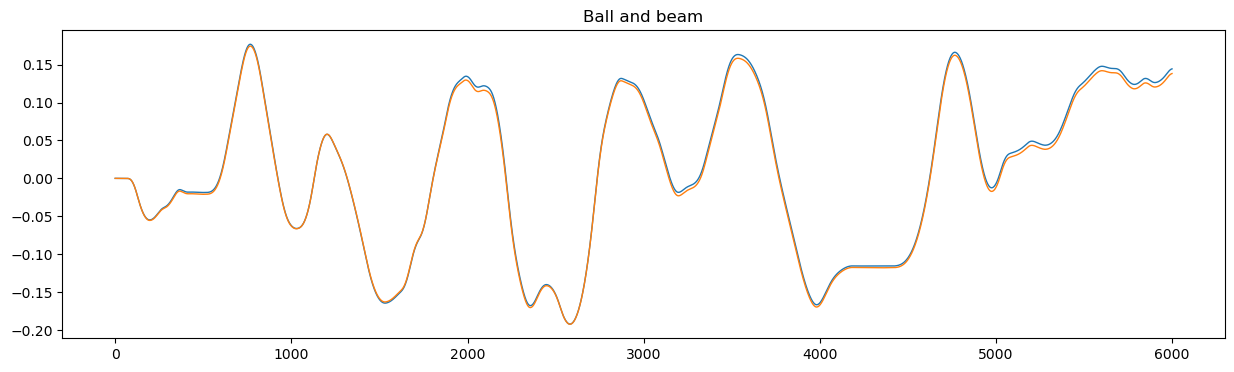

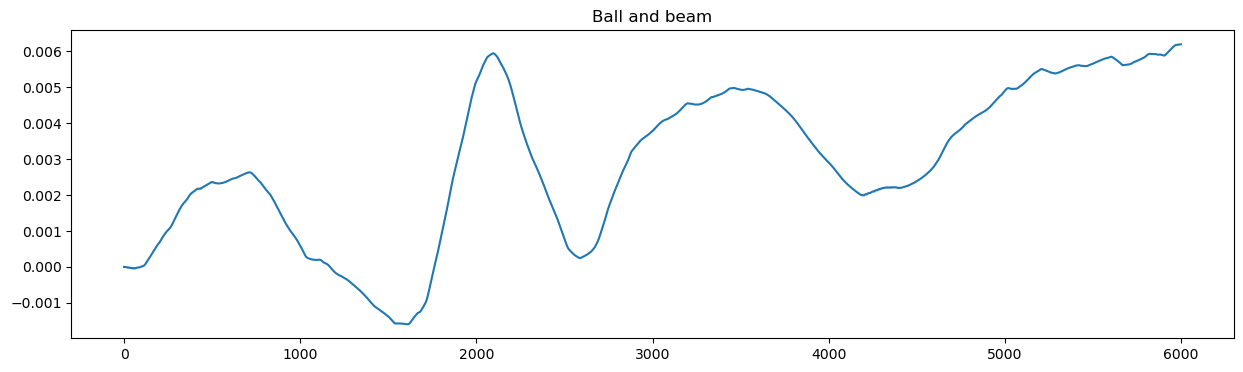

In [34]:
Y = integrate(slivre, dt)
l = 1
plt.figure(figsize=(15,4));plt.title("Ball and beam")
#plt.plot((y[1:]-y[:-1])/dt)
plt.plot(Y, linewidth=l)
plt.plot(y, linewidth=l)
plt.show()
plt.figure(figsize=(15,4));plt.title("Ball and beam")
plt.plot(Y - y)
plt.show()

## imagens

In [24]:
'''data = np.vstack((ui, yi, t)).T
#print(un.shape, s.shape, data.shape)
np.savetxt("data/ballBeamNoise.csv", data, delimiter=",", fmt="%.6f", header="input,output,time", comments="")'''

'data = np.vstack((ui, yi, t)).T\n#print(un.shape, s.shape, data.shape)\nnp.savetxt("data/ballBeamNoise.csv", data, delimiter=",", fmt="%.6f", header="input,output,time", comments="")'

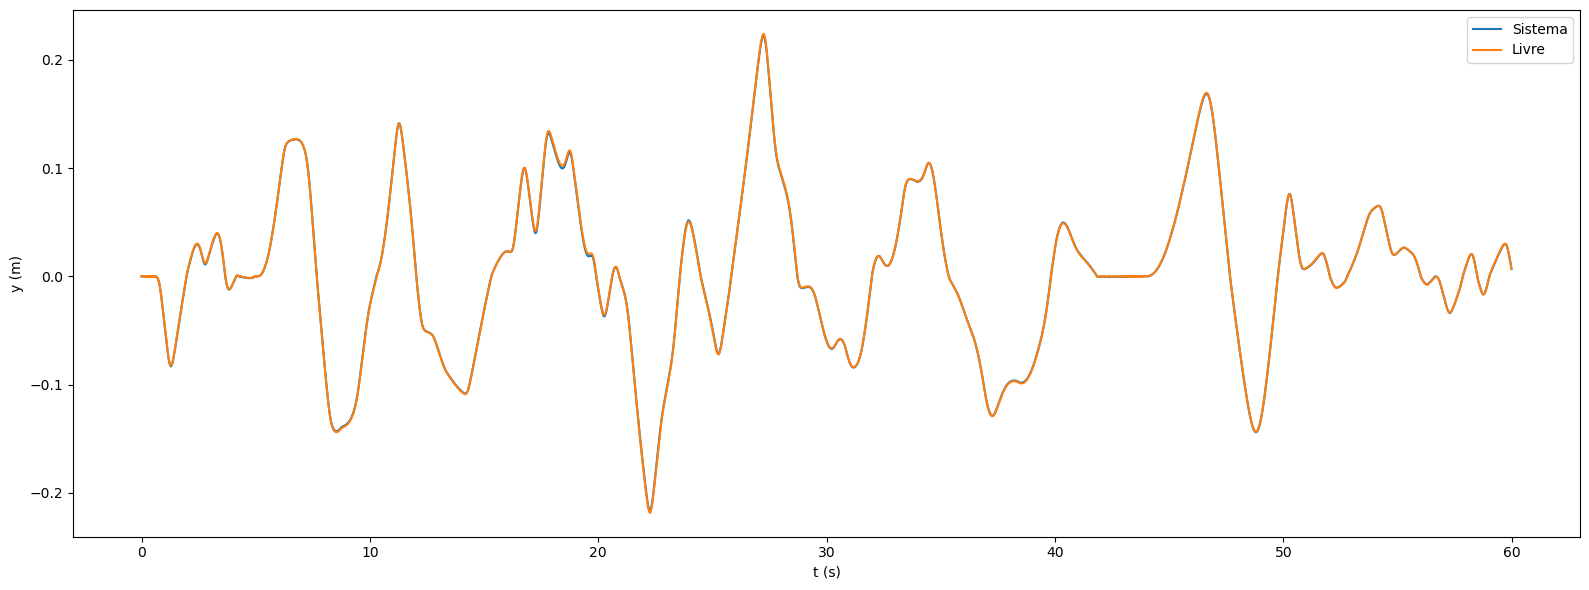

In [25]:
l = 1.5
plt.figure(figsize=(16, 6))
plt.plot(t, yi[output].T, label='Sistema', linewidth=l)
plt.plot(t, slivre, label='Livre', linewidth=l)
#plt.ylim((-0.2, 0.2))

plt.ylabel('y (m)')
plt.xlabel('t (s)')
plt.legend()
plt.tight_layout() 
#plt.savefig('/home/jonhlucas/Downloads/periodo atual/TCC/escrita/Jonh - TCC/figuras/ballBeamEst.png')

plt.show()

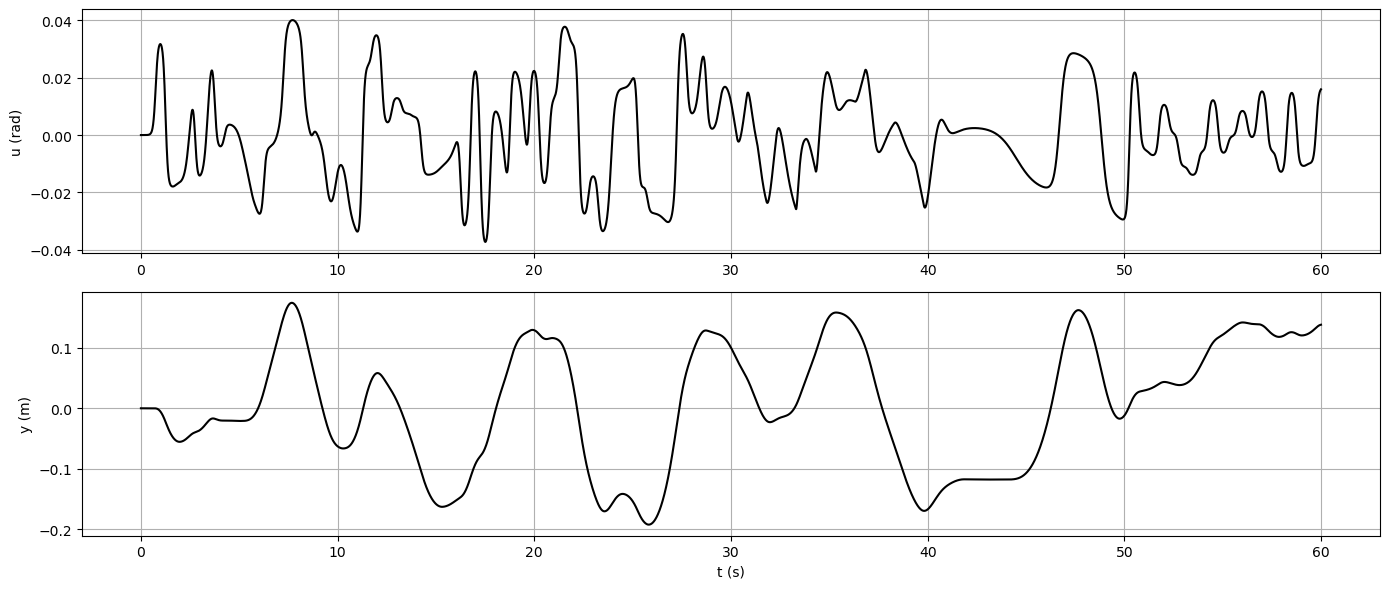

In [43]:
f, ax = plt.subplots(2, 1, figsize=[14, 6])
ax[0].plot(t, ui[0].T, label='Entrada', color='black')
ax[0].set_ylabel('u (rad)')

ax[1].plot(t, y, label='Saída', color='black')
ax[1].set_ylabel('y (m)')
ax[1].set_xlabel('t (s)')


plt.tight_layout() 
plt.savefig('/home/jonhlucas/Downloads/periodo atual/TCC/escrita/Jonh - TCC/figuras/ballandbeamEst.png')
ax[0].grid()
ax[1].grid()
plt.show()

## antigo

# Validacao

## preparação

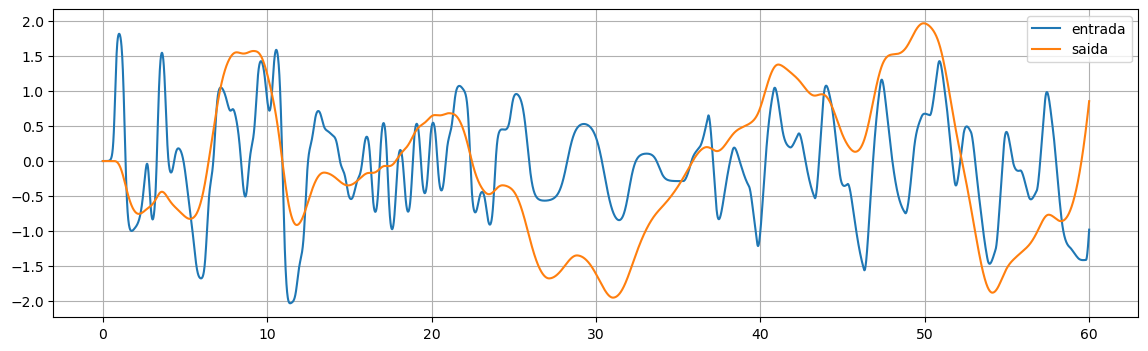

In [28]:

val_data = np.genfromtxt('data/ballBeamFrictionVal.csv', delimiter=',')[1:,:]

uVal = np.reshape(val_data[:, 0], (1, -1))
yVal = np.reshape(val_data[:, 1], (1, -1))
#yVal = yVal + np.random.uniform(-amplitude, amplitude, yVal.shape)

tVal = val_data[:, -1]
dt = val_data[1, -1]

plt.figure(figsize=(14, 4))
plt.plot(tVal, uVal.T*(180/np.pi), label="entrada")
plt.plot(tVal, yVal.T*10, label="saida")

plt.legend();plt.grid();plt.show()

## simul


Um passo a frente
RMSE: 7.087923701519437e-05 MSE: 5.0238662398561e-09 
AET: 0.33188501668656967 
MAPE: 0.04572%

Simulação livre
RMSE: 0.0005619877218232578 MSE: 3.158301994800953e-07 
AET: 2.72129290735994 
MAPE: 0.12251%


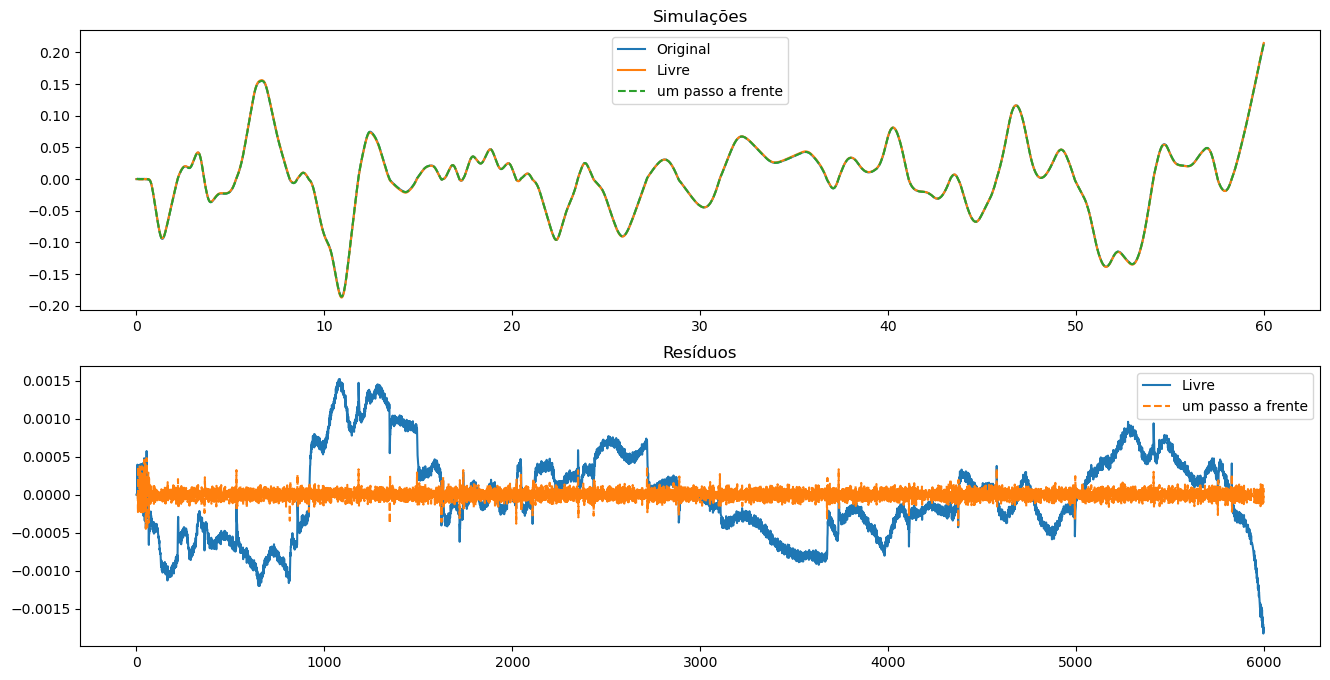

'\nSimulação livre\nRMSE: 0.0035869150526202202 MSE: 1.2865959594713516e-05 \nAET: 16.023141842724456 \nMAPE: 0.11166%\n'

In [39]:
dyVal = np.zeros(yVal.shape)
dyVal[output, 1:] = (yVal[output, 1:] - yVal[output, :-1]) / dt
valCandidatos = sselector.matrix_candidate(uVal, dyVal, **params[output], dt=dt, intg=False)

hatVal = sselector.oneStepForward2(u=uVal, y=dyVal, theta=theta, selected=selected, nb=params[output]['nb'], na=params[output]['na'], level=params[output]['level'], index=output, root=params[output]['root'], delay=params[output]['delay'], diff=params[output]['diff'], dt=dt, intg=False, nonlinear=params[output]['nonlinear'], ymodifier=params[output]['ymodifier'])
print("\nUm passo a frente")
metrics(dyVal, hatVal)

'''
vPsi = valCandidatos[selected, :]
hatVal = np.zeros(yVal.shape[1])
hatVal[:pad] = yVal[output, :pad]
hatVal[pad:] = vPsi.T @ theta
print("\nUm passo a frente")
metrics(yVal, hatVal)

hatVal = sselector.oneStepForward(uVal, yVal, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['delay'], dt=0.1)
print("\nUm passo a frente")
metrics(yVal, hatVal)
'''

valLivre = sselector.predict(uVal, yVal, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['delay'], params[output]['diff'], dt=0.1)
print("\nSimulação livre")
metrics(dyVal, valLivre)

f, ax = plt.subplots(2,1, figsize=[16,8])

ax[0].plot(tVal, dyVal.T, label='Original')
ax[0].plot(tVal, valLivre, label='Livre')
ax[0].plot(tVal, hatVal, '--', label='um passo a frente')
ax[0].set_title("Simulações");ax[0].legend()


ax[1].plot(dyVal[output].T - valLivre, label='Livre')
ax[1].plot(dyVal[output].T - hatVal, '--', label='um passo a frente')
ax[1].set_title("Resíduos");ax[1].legend()
plt.show()

'''
Simulação livre
RMSE: 0.0005619877218232578 MSE: 3.158301994800953e-07 
AET: 2.72129290735994 
MAPE: 0.12251%
'''

## arquivo

In [30]:
'''data = np.vstack((uVal, yVal, tVal)).T
#print(un.shape, s.shape, data.shape)
np.savetxt("data/ballBeamDataVal.csv", data, delimiter=",", fmt="%.6f", header="input,output,time", comments="")'''

'data = np.vstack((uVal, yVal, tVal)).T\n#print(un.shape, s.shape, data.shape)\nnp.savetxt("data/ballBeamDataVal.csv", data, delimiter=",", fmt="%.6f", header="input,output,time", comments="")'

[Y1.1 cos(U1.2)*sign(Y1.1) U1.8*cos(Y1.1) Y1.8*cos(U1.5) Y1.2 U1.4 Y1.3
 Y1.4]


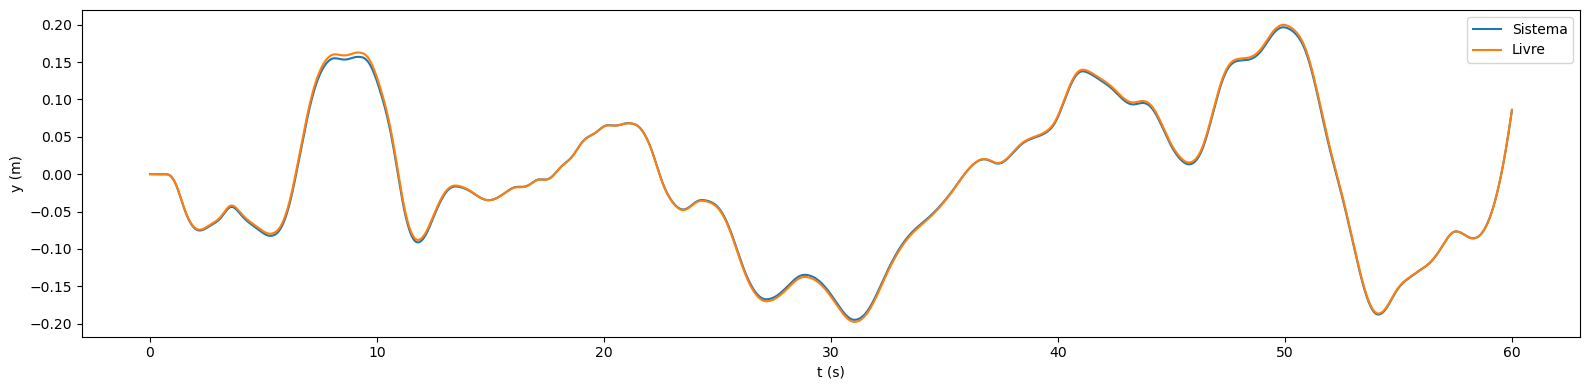

In [48]:
l = 1.5
print(model)
plt.figure(figsize=(16, 4))
plt.plot(tVal, yVal[output].T, label='Sistema', linewidth=l)
plt.plot(tVal, integrate(valLivre, dt), label='Livre', linewidth=l)
#plt.ylim((-0.2, 0.2))

plt.ylabel('y (m)')
plt.xlabel('t (s)')
plt.legend()
plt.tight_layout() 
#plt.savefig('/home/jonhlucas/Downloads/periodo atual/TCC/escrita/Jonh - TCC/figuras/ballBeamVal.png')

plt.show()

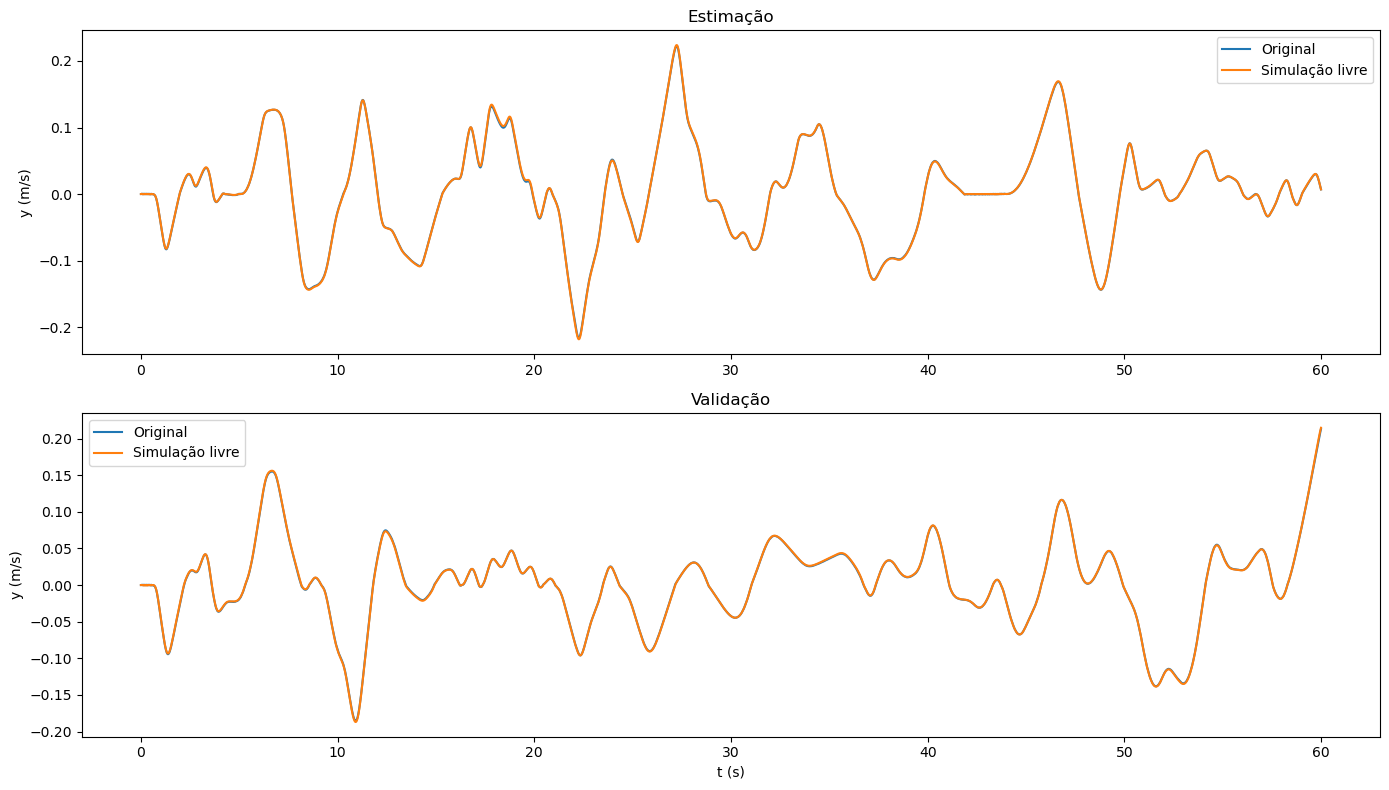

In [56]:

f, ax = plt.subplots(2, 1, figsize=[14, 8])
ax[0].plot(t, yi[output], label='Original')
ax[0].plot(t, slivre, label='Simulação livre')
ax[0].set_ylabel('y (m/s)')
'''ax[0].set_ylim(-0.1, 4.1)
ax[0].set_xlim(0, 10)'''
ax[0].set_title("Estimação")
ax[0].legend()

ax[1].plot(t, dyVal[output], label='Original')
ax[1].plot(t, valLivre, label='Simulação livre')
ax[1].set_ylabel('y (m/s)')
ax[1].set_xlabel('t (s)')
'''ax[1].set_ylim(-0.1, 4.1)
ax[1].set_xlim(0, 10)'''
ax[1].set_title("Validação")
ax[1].legend()

plt.tight_layout() 
#plt.savefig('/home/jonhlucas/Downloads/periodo atual/TCC/escrita/Jonh - TCC/figuras/ballBeamResult.png')

plt.show()

# Residuo

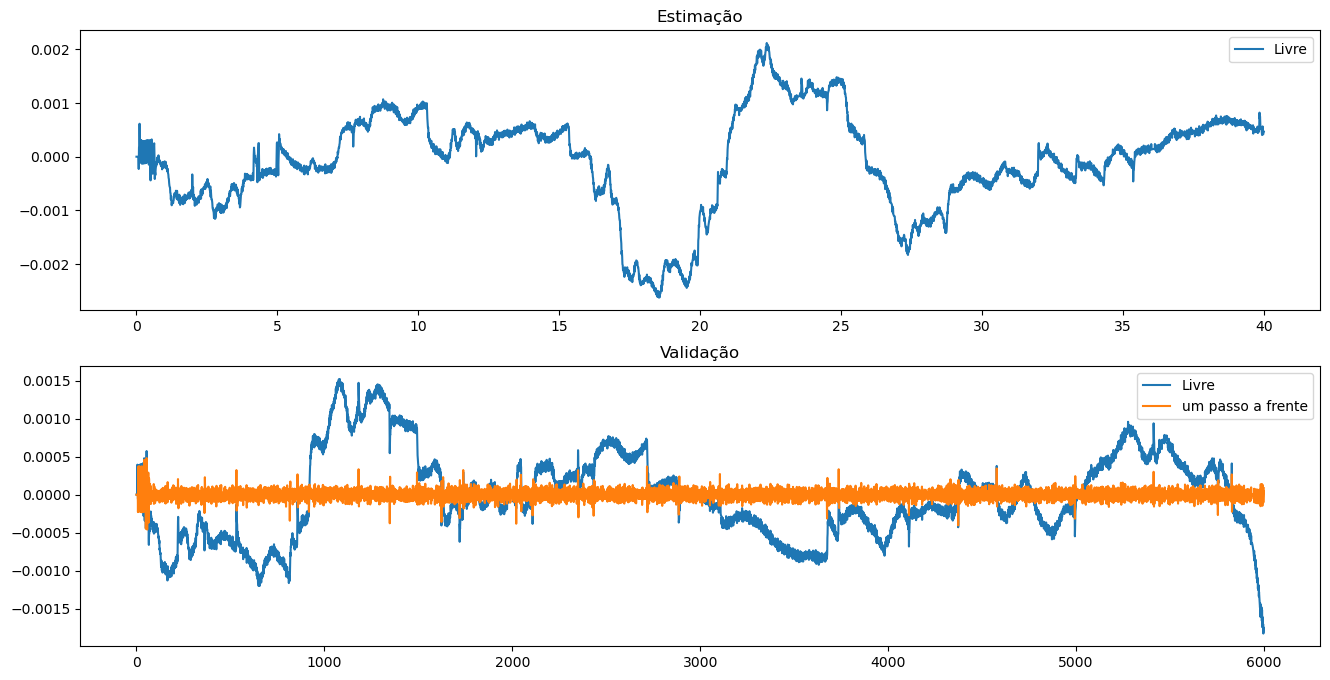

In [50]:
f, ax = plt.subplots(2,1, figsize=[16,8])

ax[0].plot(t[:4000], yi[output, :4000].T - slivre[:4000], label='Livre')
#ax[0].plot(t[:4000], yi[output, :4000].T - yhat[:4000], label='um passo a frente')
ax[0].set_title("Estimação");ax[0].legend()


ax[1].plot(dyVal[output].T - valLivre, label='Livre')
ax[1].plot((dyVal[output].T - hatVal)[:], label='um passo a frente')
ax[1].set_title("Validação");ax[1].legend()
plt.show()

# Simple Narx

[Y1.1 U1.2 U1.8 Y1.8 Y1.2] [ 0.94484263 -0.05570347  0.05080386 -0.16165546  0.21671457] [1, 9, 15, 8, 2]

Simulação livre
RMSE: 0.01398089200797152 MSE: 0.0001954653413385619 
AET: 64.61127688493556 
MAPE: 1.26624%

Um passo a frente
RMSE: 9.485149199300798e-05 MSE: 8.996805533299658e-09 
AET: 0.41716134391841797 
MAPE: 0.14524%


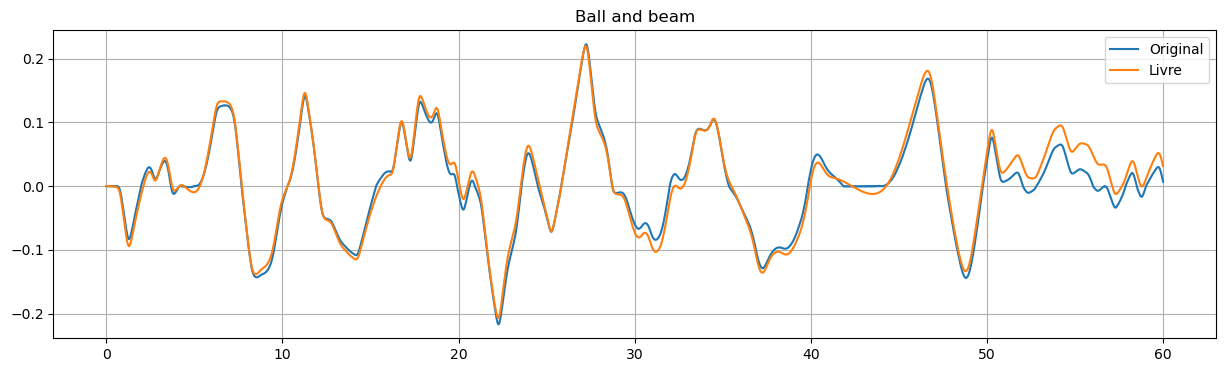

In [13]:

output = 0  
num = [6]
params = []
params.append({'nb':[8],'na':[8], 'level':3, 'nonlinear':[0,0,0,0,0], 'root':False, 'delay':1, 'diff':False, 'ymodifier':[0,0]})

sselector = structureSelector()
#clip.setLimit(-0.2, 0.2)
ss = sselector.symbolic_regressors(**params[output], intg=False)

vCandidatos = sselector.matrix_candidate(ui, yi, **params[output], dt=dt, intg=False)

pad = max(max(params[output]['nb']), max(params[output]['na']))
psi, selected  = sselector.semp(vCandidatos.T, yi[output, pad:], num[output], 1e-13)

model = ss[selected]

theta = LSM(yi[output, pad:], psi)
print(model, theta, selected)

model = ss[selected]

polinomial_slivre = sselector.predict(ui, yi, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['delay'], params[output]['diff'], dt=dt, intg=False)
print("\nSimulação livre")
metrics(yi, polinomial_slivre)
'''
yhat = sselector.oneStepForward(ui, yi, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['diff'], dt=dt, intg=False)
print("\nUm passo a frente")
metrics(yi, yhat)
'''
yhat = sselector.oneStepForward2(u=ui, y=yi, theta=theta, selected=selected, nb=params[output]['nb'], na=params[output]['na'], level=params[output]['level'], index=output, root=params[output]['root'], delay=params[output]['delay'], diff=params[output]['diff'], dt=dt, intg=False, nonlinear=params[output]['nonlinear'], ymodifier=params[output]['ymodifier'])
print("\nUm passo a frente")
metrics(yi, yhat)

plt.figure(figsize=(15,4));plt.title("Ball and beam")
plt.plot(t, yi.T, label='Original');plt.plot(t, polinomial_slivre, label='Livre')
plt.legend();plt.grid();plt.show()


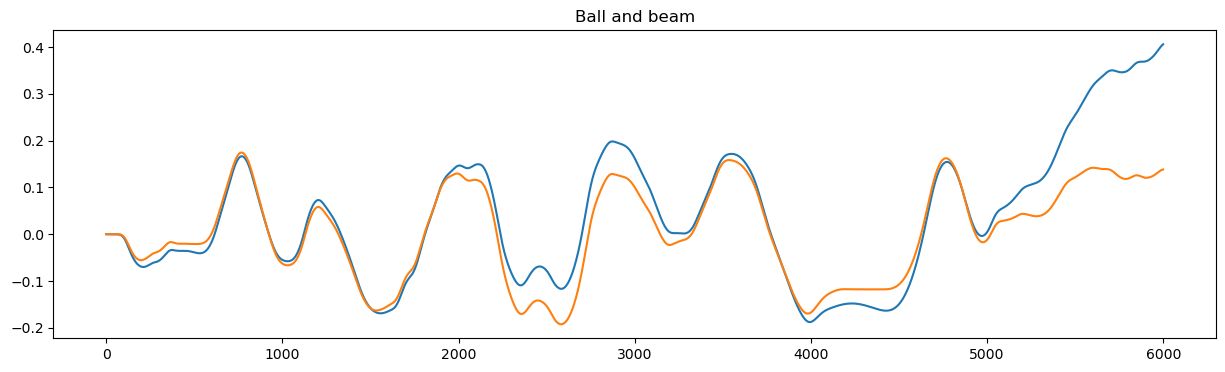

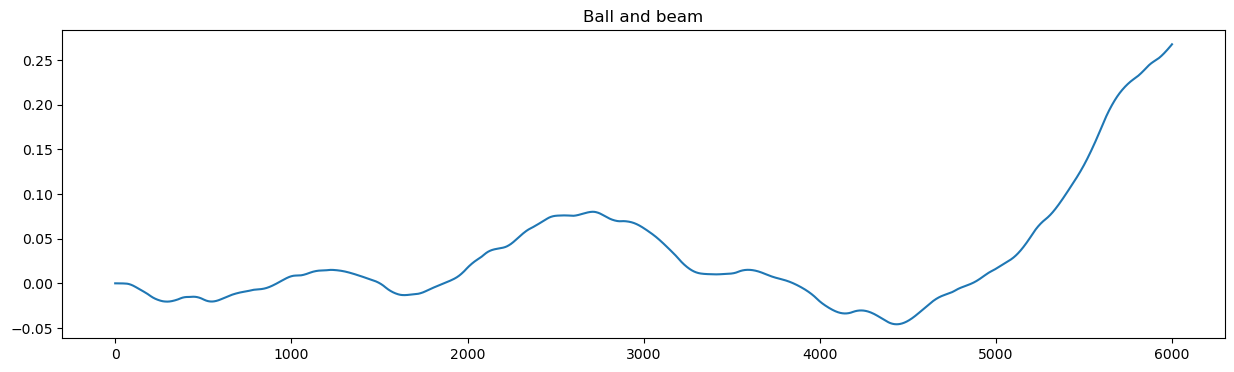

In [8]:
Y = integrate(polinomial_slivre, dt)
plt.figure(figsize=(15,4));plt.title("Ball and beam")
#plt.plot((y[1:]-y[:-1])/dt)
plt.plot(Y)
plt.plot(y)
plt.show()
plt.figure(figsize=(15,4));plt.title("Ball and beam")
plt.plot(Y - y)
plt.show()


Simulação livre
RMSE: 0.02453426030480195 MSE: 0.0006019299287037807 
AET: 113.11708589378951 
MAPE: 1.94228%

Um passo a frente
RMSE: 8.860495950509549e-05 MSE: 7.850838848899611e-09 
AET: 0.3916970727213601 
MAPE: 0.05811%


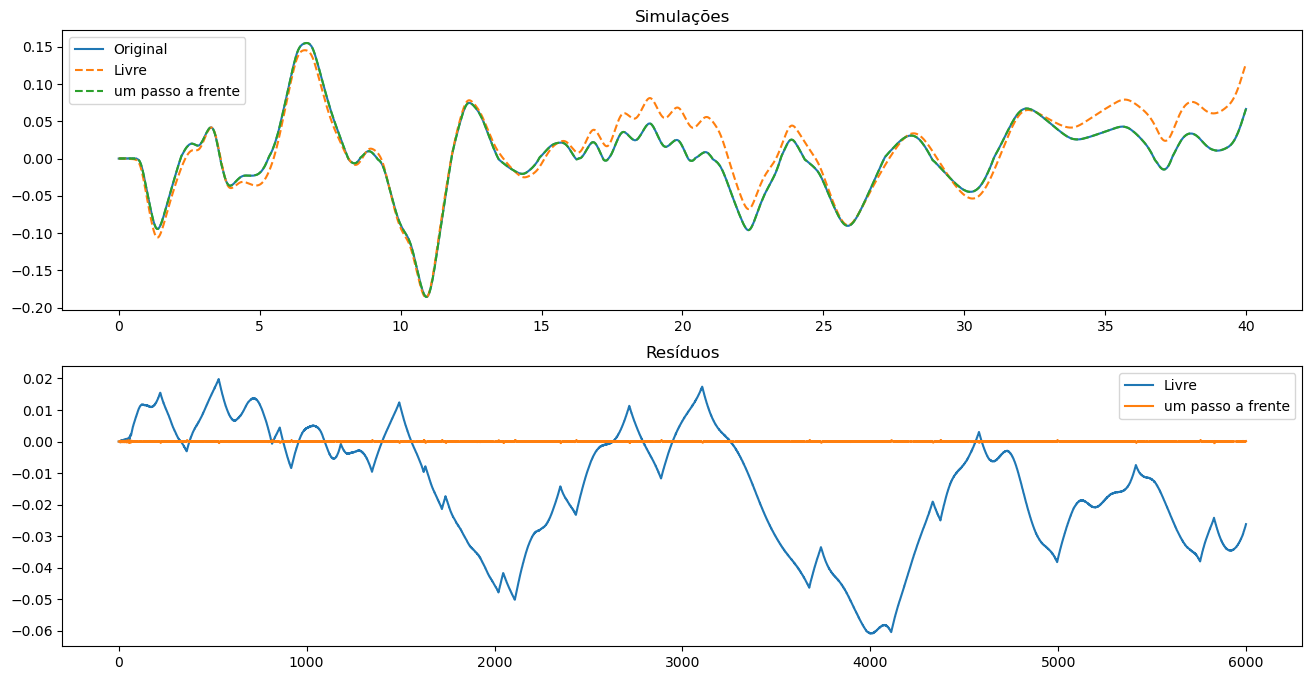

'\nhatVal = sselector.oneStepForward(uVal, yVal, theta, ss[selected], params[output][\'nb\'], params[output][\'na\'], output, params[output][\'delay\'], dt=0.1)\nprint("\nUm passo a frente")\nmetrics(yVal, hatVal)\n\nSimulação livre\nRMSE: 0.005098985623454428 MSE: 2.5999654388194944e-05 \nAET: 17.15177680094702 \nMAPE: 0.18957%\n\nUm passo a frente\nRMSE: 8.049090493171363e-05 MSE: 6.47878577672616e-09 \nAET: 0.07288238178705425 \nMAPE: 0.03893%\n'

In [21]:
polinomial_valLivre = sselector.predict(uVal, dyVal, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['delay'], params[output]['diff'], dt=0.1)

print("\nSimulação livre")
metrics(dyVal, polinomial_valLivre)

hatVal = sselector.oneStepForward2(u=uVal, y=dyVal, theta=theta, selected=selected, nb=params[output]['nb'], na=params[output]['na'], level=params[output]['level'], index=output, root=params[output]['root'], delay=params[output]['delay'], diff=params[output]['diff'], dt=dt, intg=False, nonlinear=params[output]['nonlinear'], ymodifier=params[output]['ymodifier'])
print("\nUm passo a frente")
metrics(dyVal, hatVal)

f, ax = plt.subplots(2,1, figsize=[16,8])

ax[0].plot(tVal[ :4000], dyVal[output, :4000].T, label='Original')
ax[0].plot(tVal[ :4000], polinomial_valLivre[ :4000], '--', label='Livre')
ax[0].plot(tVal[ :4000], hatVal[ :4000], '--', label='um passo a frente')
ax[0].set_title("Simulações");ax[0].legend()


ax[1].plot(dyVal[output].T - polinomial_valLivre, label='Livre')
ax[1].plot(dyVal[output].T - hatVal, label='um passo a frente')
ax[1].set_title("Resíduos");ax[1].legend()
plt.show()

'''
hatVal = sselector.oneStepForward(uVal, yVal, theta, ss[selected], params[output]['nb'], params[output]['na'], output, params[output]['delay'], dt=0.1)
print("\nUm passo a frente")
metrics(yVal, hatVal)

Simulação livre
RMSE: 0.005098985623454428 MSE: 2.5999654388194944e-05 
AET: 17.15177680094702 
MAPE: 0.18957%

Um passo a frente
RMSE: 8.049090493171363e-05 MSE: 6.47878577672616e-09 
AET: 0.07288238178705425 
MAPE: 0.03893%
'''

# Comparativo

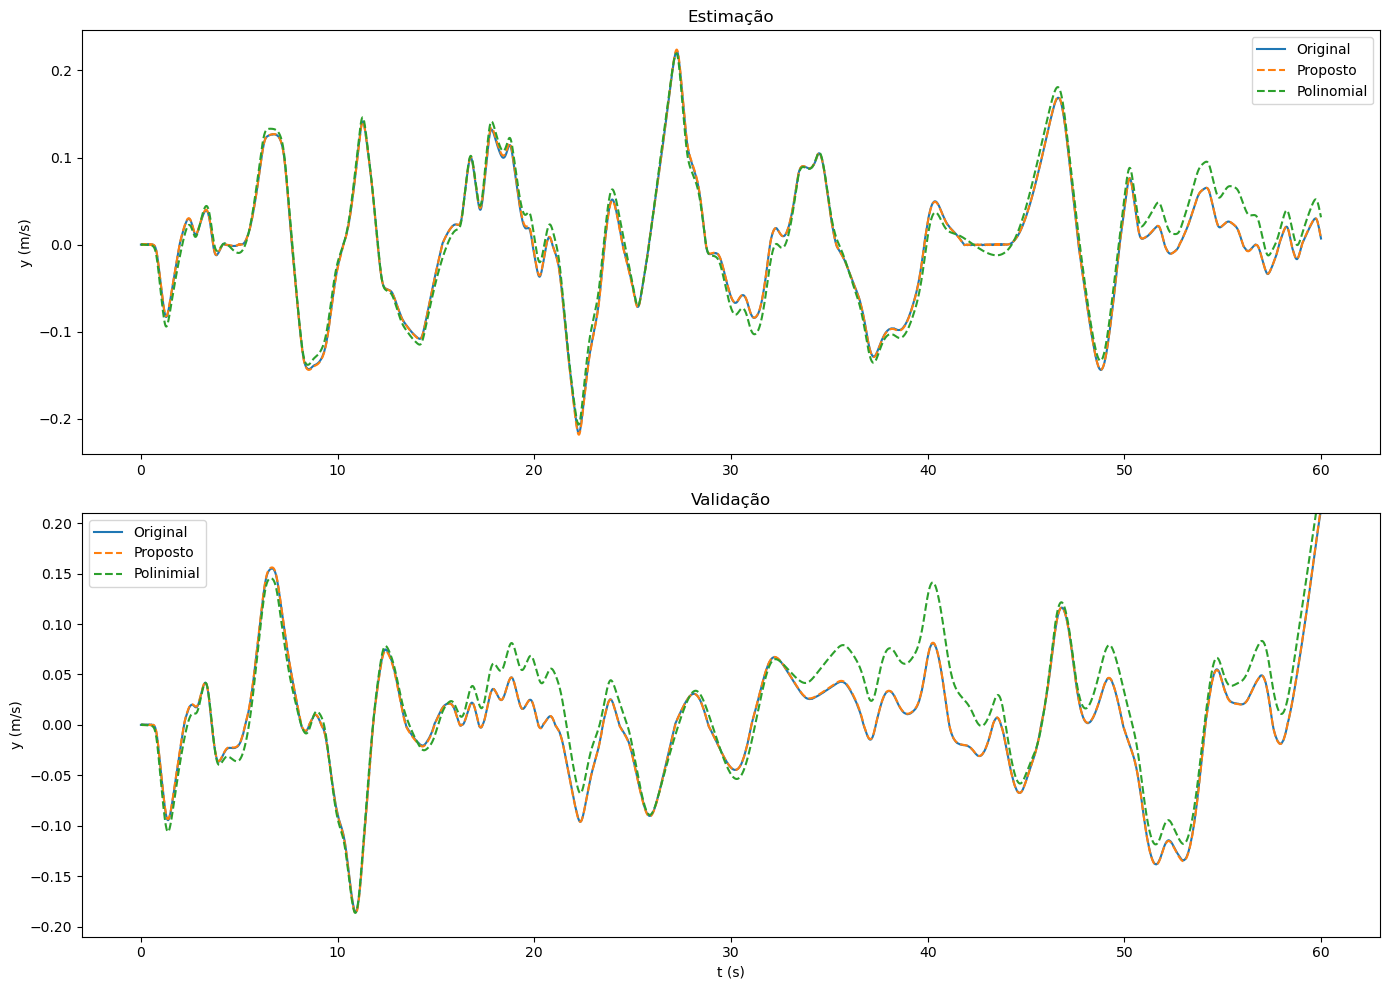

In [47]:
p = np.arange(0, 10, 0.02)

f, ax = plt.subplots(2, 1, figsize=[14, 10])
ax[0].plot(t, yi.T, label='Original')
ax[0].plot(t, slivre, '--', label='Proposto')
ax[0].plot(t, polinomial_slivre, '--', label='Polinomial')

ax[0].set_ylabel('y (m/s)')

ax[0].set_title("Estimação")
ax[0].legend()

ax[1].plot(t, dyVal.T, label='Original')
ax[1].plot(t, valLivre, '--', label='Proposto')
ax[1].plot(t, polinomial_valLivre, '--', label='Polinimial')
ax[1].set_ylabel('y (m/s)')
ax[1].set_xlabel('t (s)')
ax[1].set_ylim(-0.21, 0.21)
ax[1].set_title("Validação")
ax[1].legend()

plt.tight_layout() 
#plt.savefig('/home/jonhlucas/Downloads/periodo atual/TCC/escrita/Jonh - TCC/figuras/ballBeamComparate.png')

plt.show()